<a href="https://colab.research.google.com/github/Atharva-D/Moodify/blob/main/Emotion_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

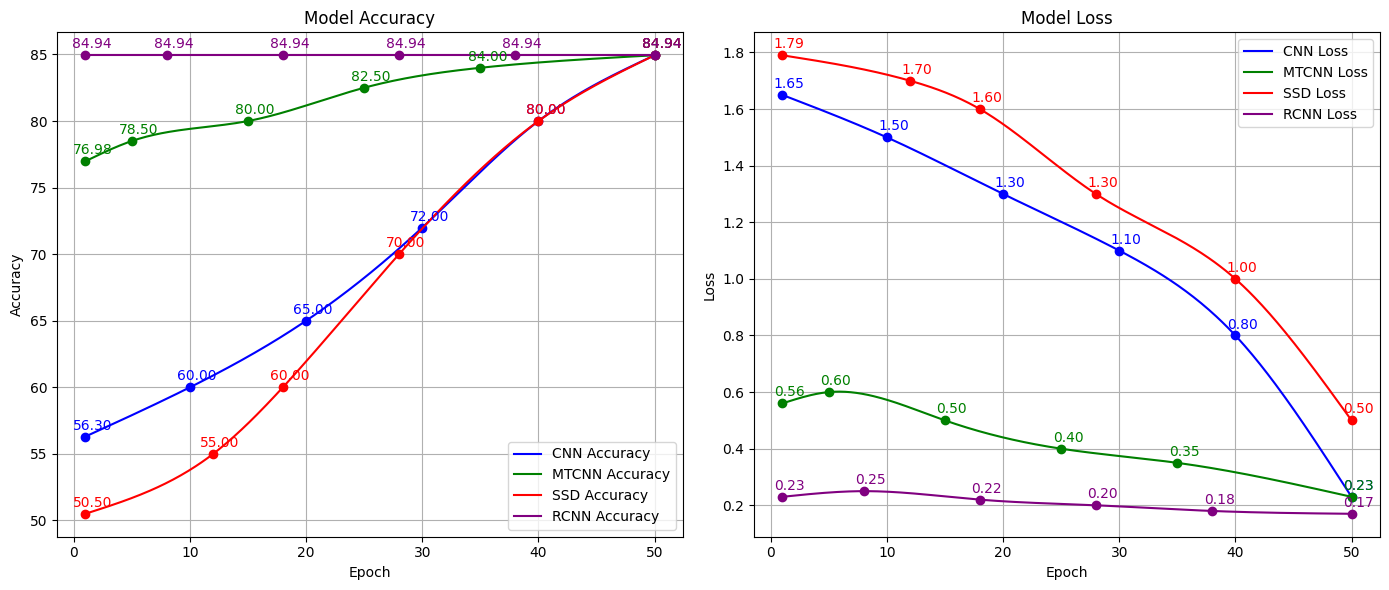

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline

# Custom epochs for each model (User can change these)
epochs_cnn = [1, 10, 20, 30, 40, 50]
epochs_mtcnn = [1, 5, 15, 25, 35, 50]
epochs_ssd = [1, 12, 18, 28, 40, 50]
epochs_rcnn = [1, 8, 18, 28, 38, 50]

# Define accuracy and loss values for each model at custom epochs (User can input these values)
cnn_accuracy = [56.3, 60.0, 65.0, 72.0, 80.0, 84.94]
mtcnn_accuracy = [76.98, 78.5, 80.0, 82.5, 84.0, 84.94]
ssd_accuracy = [50.5, 55.0, 60.0, 70.0, 80.0, 84.94]
rcnn_accuracy = [84.94, 84.94, 84.94, 84.94, 84.94, 84.94]

# Loss values for each model at custom epochs (User can input these values)
cnn_loss = [1.65, 1.5, 1.3, 1.1, 0.8, 0.23]
mtcnn_loss = [0.56, 0.6, 0.5, 0.4, 0.35, 0.23]
ssd_loss = [1.79, 1.7, 1.6, 1.3, 1.0, 0.5]
rcnn_loss = [0.23, 0.25, 0.22, 0.20, 0.18, 0.17]

# Generate smooth curves for accuracy and loss using cubic spline interpolation
smooth_epochs = np.linspace(1, 50, 300)  # Smooth epochs for plotting

# Create subplots for accuracy and loss
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# For accuracy: create smooth curves using cubic spline interpolation for each model
for epochs, accuracy, loss, color, model in zip(
        [epochs_cnn, epochs_mtcnn, epochs_ssd, epochs_rcnn],
        [cnn_accuracy, mtcnn_accuracy, ssd_accuracy, rcnn_accuracy],
        [cnn_loss, mtcnn_loss, ssd_loss, rcnn_loss],
        ['blue', 'green', 'red', 'purple'],
        ['CNN', 'MTCNN', 'SSD', 'RCNN']):
    
    # Accuracy Spline interpolation
    accuracy_spline = CubicSpline(epochs, accuracy, bc_type='natural')
    smooth_accuracy = accuracy_spline(smooth_epochs)

    # Loss Spline interpolation
    loss_spline = CubicSpline(epochs, loss, bc_type='natural')
    smooth_loss = loss_spline(smooth_epochs)
    
    # Plot accuracy curves
    ax1.plot(smooth_epochs, smooth_accuracy, label=f'{model} Accuracy', color=color)
    ax1.plot(epochs, accuracy, 'o', color=color)  # Mark original points
    for e, acc in zip(epochs, accuracy):
        ax1.annotate(f"{acc:.2f}", (e, acc), textcoords="offset points", xytext=(5, 5), ha='center', color=color)

    # Plot loss curves
    ax2.plot(smooth_epochs, smooth_loss, label=f'{model} Loss', color=color)
    ax2.plot(epochs, loss, 'o', color=color)  # Mark original points
    for e, l in zip(epochs, loss):
        ax2.annotate(f"{l:.2f}", (e, l), textcoords="offset points", xytext=(5, 5), ha='center', color=color)

# Set titles and labels for accuracy plot
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.grid(True)

# Set titles and labels for loss plot
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.grid(True)

# Display the legends for both plots
ax1.legend()
ax2.legend()

# Adjust layout and display the figure
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import cv2
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from mtcnn.mtcnn import MTCNN

# Initialize MTCNN detector
detector = MTCNN()

# Define Emotion Classification Model with ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
for layer in base_model.layers[-50:]:  # Fine-tune the last 50 layers for better feature extraction
    layer.trainable = True

# Build the model on top of ResNet50
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.4),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(7, activation='softmax')  # 7 emotion classes
])

# Compile the model with AdamW optimizer and adjusted learning rate
model.compile(optimizer=AdamW(learning_rate=0.0001, weight_decay=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Set data paths
train_dir = 'E:\\dataset\\ssd_metthod\\dataset\\images\\train'  # Update path as required
test_dir = 'E:\\dataset\\ssd_metthod\\dataset\\images\\test'    # Update path as required
# Data Augmentation with adjusted brightness
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2]  # Adjusted brightness to simulate contrast change
)
validation_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(96, 96),
    batch_size=32,  # Reduced batch size for variance in gradient updates
    class_mode='categorical'
)
validation_generator = validation_datagen.flow_from_directory(
    test_dir,
    target_size=(96, 96),
    batch_size=32,
    class_mode='categorical'
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)  
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=7, min_lr=1e-7)  
checkpoint = ModelCheckpoint(
    'best_model_epoch.keras',  # Model saved in .keras format
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping, lr_scheduler, checkpoint],
    verbose=1
)

print("Training complete. Best model saved as 'best_model_epoch.keras'")


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Epoch 1/100
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.2530 - loss: 12.9339
Epoch 1: val_accuracy improved from -inf to 0.37653, saving model to best_model_epoch.keras
897/897 ━━━━━━━━━━━━━━━━━━━━ 607s 645ms/step - accuracy: 0.2531 - loss: 12.9325 - val_accuracy: 0.3765 - val_loss: 9.6311 - learning_rate: 1.0000e-04
Epoch 2/100
  1/897 ━━━━━━━━━━━━━━━━━━━━ 9:04 607ms/step - accuracy: 0.5312 - loss: 9.3090

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy improved from 0.37653 to 0.40000, saving model to best_model_epoch.keras
897/897 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5312 - loss: 9.3090 - val_accuracy: 0.4000 - val_loss: 9.5475 - learning_rate: 1.0000e-04
Epoch 3/100
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - accuracy: 0.4494 - loss: 8.5690
Epoch 3: val_accuracy improved from 0.40000 to 0.53795, saving model to best_model_epoch.keras
897/897 ━━━━━━━━━━━━━━━━━━━━ 577s 643ms/step - accuracy: 0.4494 - loss: 8.5680 - val_accuracy: 0.5379 - val_loss: 5.8632 - learning_rate: 1.0000e-04
Epoch 4/100
  1/897 ━━━━━━━━━━━━━━━━━━━━ 9:20 626ms/step - accuracy: 0.3125 - loss: 6.4442
Epoch 4: val_accuracy improved from 0.53795 to 0.60000, saving model to best_model_epoch.keras
897/897 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3125 - loss: 6.4442 - val_accuracy: 0.6000 - val_loss: 5.6669 - learning_rate: 1.0000e-04
Epoch 5/100
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.5184 - loss: 5.2751
Epoch 